In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F #F.relu(), F.maxpool2d()
import torchvision
from torchvision import datasets, transforms #, models
#datasets.ImageFolder('folder_path/train', transform)

#from torch.utils import make_grid #only for plot the images

from torch.utils.data import DataLoader, TensorDataset #make data understandable by Pytorch
#TensorDataset -> use when having seprated label variable (not in folder split)
#DataLoader -> load batches
#train_dataset = TensorDataset(tensor_train, label_train)--> construct a Pytorch ds with labels
# train_loader = DataLoader(train_dataset, batch_size, shuffle, drop_last)--> load in batches

from torchsummary import summary



In [2]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('dark_background')
import os
import numpy as np
!pip install split-folders
import splitfolders

In [3]:
# torch.cuda.is_available()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


## get the data
- load from drive
- train test split: `splitfolders.ratio()`
- dataset


In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%cd /content/drive/MyDrive/ComputerVision-Course/Assign06

/content/drive/MyDrive/ComputerVision-Course/Assign06


In [6]:
#splitfolders.ratio('CatDog', output = 'catdog_train_test_split',
#                   ratio = (0.8, 0.2), group_prefix = None, move=False, seed=2023)

#### check the size of the images

image size is  (470, 310) (500, 375) (150, 150)


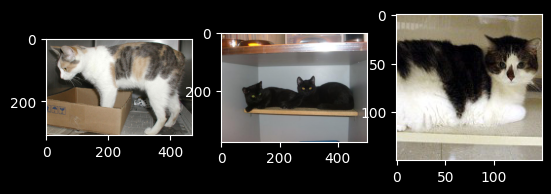

In [7]:
from PIL import Image
img_path1 = 'catdog_train_test_split/val/cat/1952.jpg' #1916,1924
img_path2 = 'catdog_train_test_split/val/cat/1916.jpg'
img_path3 = 'catdog_train_test_split/val/cat/1924.jpg'

img1 = Image.open(img_path1)
img2 = Image.open(img_path2)
img3 = Image.open(img_path3)
print('image size is ', img1.size, img2.size, img3.size)

plt.subplot(1, 3, 1)
plt.imshow(img1)
plt.subplot(1, 3, 2)
plt.imshow(img2)
plt.subplot(1, 3, 3)
plt.imshow(img3)
#plt.axis('off')

In [8]:
# # get tensor image
# test_transform = transforms.ToTensor()
# img_tr = test_transform(img1)
# img_tr.shape

In [9]:
# img_tr[0,:,:]

In [10]:
# img_tr[0,:,:].mean()

In [11]:
# img_tr[2,:,:].std()

### `transforms.Compose` data into
- tensor form
- normalized
- resize if needed

https://pytorch.org/vision/stable/transforms.html#functional-transforms

`transforms.Compose(transforms)` = Composes several transforms together.

`transforms.ToTensor()`: Convert a PIL Image or ndarray to tensor and scale the values accordingly.#
  - It converts the PIL image with a pixel range of [0, 255] to a PyTorch FloatTensor of shape (C, H, W) with a range [0.0, 1.0].
  
` `

In [12]:
# can use (mean and std) from ResNet directly for Normalization (ok for all images)

transform_cnn = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224)),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]),
                                ])

In [13]:


train_data = datasets.ImageFolder('catdog_train_test_split/train', transform = transform_cnn)
test_data = datasets.ImageFolder('catdog_train_test_split/val', transform = transform_cnn)

torch.manual_seed(2023)
batch_size = 128
train_loader = DataLoader(train_data, batch_size = 128, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data,batch_size = 128, shuffle = True, drop_last = True )

### print out the train/test data

`X,y = next(iter(train_loader))`


`print( X.data.shape )` = `torch.Size([128, 3, 224, 224])`

In [ ]:
train_data

In [ ]:
#train_data.tensors
train_data[0][0].shape

In [ ]:
train_data.classes

In [ ]:
train_loader

In [ ]:
test_loader.dataset

In [ ]:
test_loader.dataset[0][0].shape

In [9]:
X,y = next(iter(train_loader))

print('Data shapes (train):')
print( X.data.shape )

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Data shapes (train):
torch.Size([128, 3, 224, 224])


# Model 1 - Create the CNN Model


In [16]:
class ConvolutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(3, 16, 5, 1,1)
    self.conv2 = nn.Conv2d(16, 32, 5,1,1)
    self.conv3 = nn.Conv2d(32,64,5,1,1)
    self.conv4 = nn.Conv2d(64,32,5,1,1)
    self.conv5 = nn.Conv2d(32,16,5,1,1)
    self.fc = nn.LazyLinear(64)
    self.output = nn.Linear(64,2)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv3(x))
    x = F.max_pool2d(x,2,2)

    x = F.relu(self.conv4(x))
    x = F.max_pool2d(x,2,2)
    x = F.relu(self.conv5(x))
    x = F.max_pool2d(x,2,2)

    x = torch.flatten(x,1)

    x = self.fc(x)
    x = F.relu(x)
    x = self.output(x)
    return x

In [17]:
torch.manual_seed(2023)
net = ConvolutionalNetwork()
net.to(device)
net

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ConvolutionalNetwork(
  (conv1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc): LazyLinear(in_features=0, out_features=64, bias=True)
  (output): Linear(in_features=64, out_features=2, bias=True)
)

In [18]:
# count the total number of parameters in the model
summary(net,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 222, 222]           1,216
            Conv2d-2         [-1, 32, 109, 109]          12,832
            Conv2d-3           [-1, 64, 52, 52]          51,264
            Conv2d-4           [-1, 32, 24, 24]          51,232
            Conv2d-5           [-1, 16, 10, 10]          12,816
            Linear-6                   [-1, 64]          25,664
            Linear-7                    [-1, 2]             130
Total params: 155,154
Trainable params: 155,154
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 10.39
Params size (MB): 0.59
Estimated Total Size (MB): 11.56
----------------------------------------------------------------


## def function: trains the model

In [29]:
# a function that trains the model

def function2trainTheModel():

  # number of epochs
  numepochs = 20

  # create the model instance
  net = ConvolutionalNetwork()
  net = net.to(device)
  # loss function
  lossfun = nn.CrossEntropyLoss()

  # optimizer
  optimizer = torch.optim.Adam(net.parameters(),lr=.001)



  # initialize losses
  losses    = torch.zeros(numepochs)
  trainAcc  = []
  testAcc   = []


  # loop over epochs
  for epochi in range(numepochs):

    # loop over trdaaining data batches
    net.train() ## .train will backprop
    # net.cuda()

    batchAcc  = []
    batchLoss = []
    for X,y in train_loader:

      X = X.to(device)
      y = y.to(device)

      # forward pass and loss
      yHat = net(X)
      loss = lossfun(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      yHat = yHat.cpu()
      y = y.cpu()

      # compute accuracy
      matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
      matchesNumeric = matches.float()             # convert to numbers (0/1)
      accuracyPct = 100*torch.mean(matchesNumeric) # average and x100
      batchAcc.append( accuracyPct )               # add to list of accuracies
    # end of batch loop...

    # now that we've trained through the batches, get their average training accuracy

    trainAcc.append( np.mean(batchAcc) )

    # and get average losses across the batches
    losses[epochi] = np.mean(batchLoss)

    # test accuracy
    net.eval() ##.eval = not calculate gradient anymore
    X,y = next(iter(test_loader)) # extract X,y from test dataloader

     # New!
    X = X.to(device)
    y = y.to(device)

    with torch.no_grad(): # deactivates autograd
     yHat = net(X)

    # # New! bring outputs back
    # yHat = yHat.cpu()
    # y = y.cpu()

    # compare the following really long line of code to the training accuracy lines
    testAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )
    if (epochi % 10) == 0:

        print(f' epochs : {epochi}  loss : {loss : 2.2f}')
  # end epochs

  # function output
  return trainAcc,testAcc,losses,net


In [30]:
trainAcc,testAcc,losses,net = function2trainTheModel()

 epochs : 0  loss :  0.69
 epochs : 10  loss :  0.51


In [31]:
print('train accuracy', trainAcc[-1])
print('test accuracy', testAcc)

train accuracy 88.44401
test accuracy [tensor(50., device='cuda:0'), tensor(67.1875, device='cuda:0'), tensor(63.2812, device='cuda:0'), tensor(56.2500, device='cuda:0'), tensor(52.3438, device='cuda:0'), tensor(69.5312, device='cuda:0'), tensor(63.2812, device='cuda:0'), tensor(71.0938, device='cuda:0'), tensor(67.1875, device='cuda:0'), tensor(71.8750, device='cuda:0'), tensor(68.7500, device='cuda:0'), tensor(71.8750, device='cuda:0'), tensor(72.6562, device='cuda:0'), tensor(75., device='cuda:0'), tensor(69.5312, device='cuda:0'), tensor(75.7812, device='cuda:0'), tensor(78.1250, device='cuda:0'), tensor(78.1250, device='cuda:0'), tensor(79.6875, device='cuda:0'), tensor(78.1250, device='cuda:0')]


In [40]:
testAcc = [tensor.item() for tensor in testAcc]

In [32]:
torch.save(net.state_dict(),'MyTrainedModel.pt')

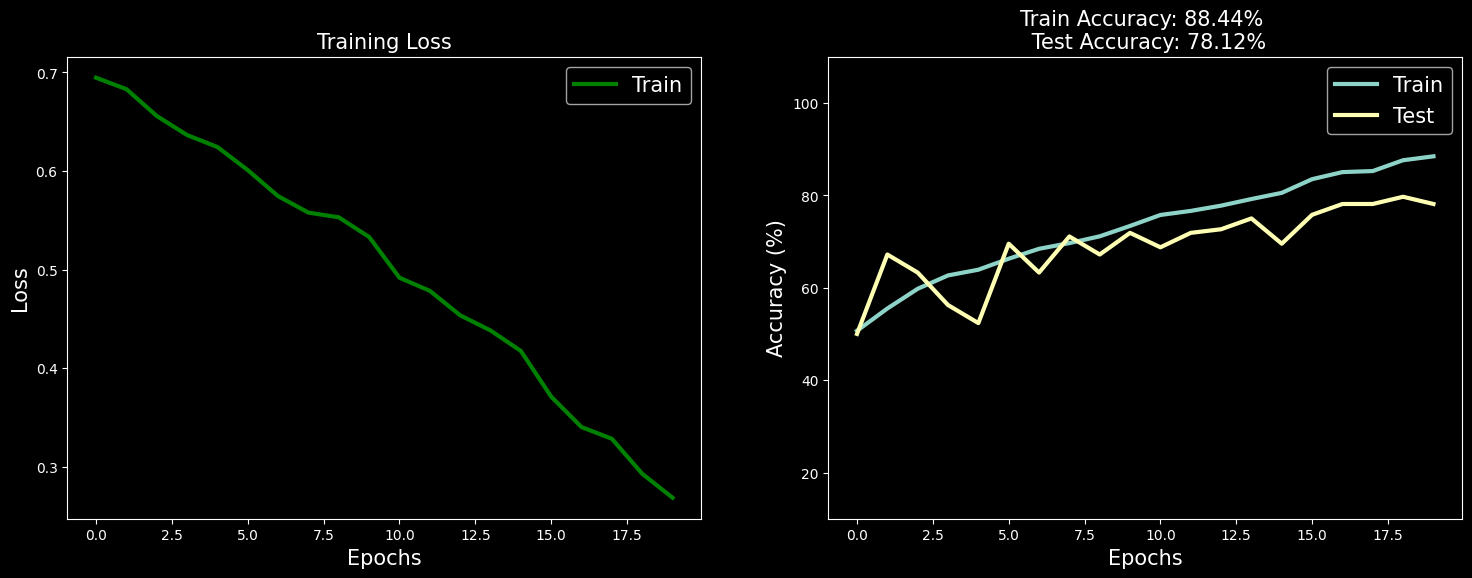

In [41]:
fig,ax = plt.subplots(1,2,figsize=(18,6))

ax[0].plot(losses, 'g', lw = 3, label = 'Train')
ax[0].set_xlabel('Epochs', fontsize = 15)
ax[0].set_ylabel('Loss', fontsize = 15)
ax[0].legend(fontsize = 15)
ax[0].set_title('Training Loss', fontsize = 15)

ax[1].plot(trainAcc, label ='Train', lw = 3)
ax[1].plot(testAcc, label ='Test', lw = 3)
ax[1].set_xlabel('Epochs', fontsize = 15)
ax[1].set_ylabel('Accuracy (%)', fontsize = 15)
ax[1].set_ylim([10,110])
ax[1].set_title(f'Train Accuracy: {trainAcc[-1]:.2f}% \n Test Accuracy: {testAcc[-1]:.2f}%', fontsize = 15)
ax[1].legend(fontsize = 15)

plt.show()

# Model 2 - use ResNet

In [15]:
import torchvision

resnet = torchvision.models.resnet18('ResNet18_Weights.DEFAULT')


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 244MB/s]


In [16]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [17]:

summary(resnet.to(device),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [18]:
resnet.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## freeze / unfreeze parameters

In [19]:
# freeze all parameters
for p in resnet.parameters():
  p.required_grad = False

# change the final layer -> add more layers
for param in resnet.layer4.parameters():
  param.required_grad = True
for param in resnet.layer3.parameters():
  param.required_grad = True
for param in resnet.avgpool.parameters():
  param.required_grad = True



## construct new FC layers

In [20]:
# Parameters of newly constructed modules have requires_grad=True by default
#num_ftrs = resnet.fc.in_features

# replace 1 FC with 4new FC 512->256->128-> 64-> 2)

resnet.fc = nn.Sequential(
    nn.Linear(in_features=512, out_features=256, bias=False),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=64, bias=True),
    nn.ReLU(),
    nn.Linear(in_features=64, out_features=2, bias=True)
)

resnet.to(device)

lossfun = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam([
                                          {"params": resnet.layer3.parameters(), "lr": 0.0001},
                                          {"params": resnet.layer4.parameters(), "lr": 0.0001},
                                          {"params": resnet.avgpool.parameters(), "lr": 0.0001},
                                          {"params": resnet.fc[0].parameters(), "lr": 0.0001},
                                          {"params": resnet.fc[2].parameters(), "lr": 0.001},
                                          {"params": resnet.fc[4].parameters(), "lr": 0.001},
    ],
    lr = 0.001, betas=(0.9, 0.999), weight_decay=0.004
)

## Train the model

In [21]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet.parameters(),lr = 0.001, weight_decay = 0.004)


In [22]:
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  resnet.train() # switch to train mode

  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = resnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  resnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU

    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = resnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Finished epoch 1/10. Test accuracy = 91.15%
Finished epoch 2/10. Test accuracy = 82.94%
Finished epoch 3/10. Test accuracy = 81.25%
Finished epoch 4/10. Test accuracy = 86.07%
Finished epoch 5/10. Test accuracy = 57.16%
Finished epoch 6/10. Test accuracy = 91.93%
Finished epoch 7/10. Test accuracy = 66.41%
Finished epoch 8/10. Test accuracy = 91.54%
Finished epoch 9/10. Test accuracy = 91.28%
Finished epoch 10/10. Test accuracy = 91.41%


## Plot

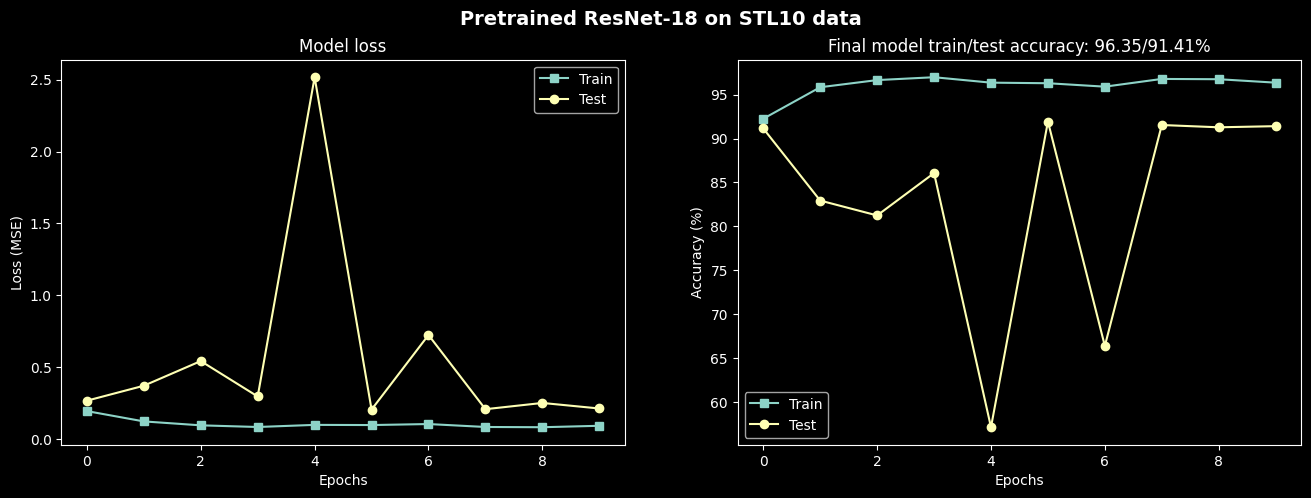

In [23]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained ResNet-18 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

# Model 3 - use VGG16

In [8]:
# transformations
transform_vgg16 = transforms.Compose([ transforms.ToTensor(), # normalizes to range [0,1]
                                      transforms.Resize((224,224)),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225]) # further normalization
                       ])



train_data = datasets.ImageFolder('catdog_train_test_split/train', transform = transform_vgg16)
test_data = datasets.ImageFolder('catdog_train_test_split/val', transform = transform_vgg16)

torch.manual_seed(2023)
batch_size = 128
train_loader = DataLoader(train_data, batch_size = 128, shuffle = True, drop_last = True)
test_loader = DataLoader(test_data,batch_size = 128, shuffle = True, drop_last = True )

In [9]:
for X,y in train_loader:
  break
print(X.shape)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([128, 3, 224, 224])


In [10]:
vggnet = torchvision.models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 255MB/s]


In [11]:
vggnet

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [12]:
from torchsummary import summary
summary(vggnet.to(device),(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [13]:
for p in vggnet.parameters():
    p.requires_grad = False

In [14]:
# change the final layer (this time soft-coded!)

## there are 6 layers in VGG-16, choose the 6th layer -> change the final classes (from 1000) to 10
vggnet.classifier[6] = nn.Linear(vggnet.classifier[6].in_features,  2)

In [15]:
vggnet.to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

## train the model

In [16]:
lossfun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(vggnet.parameters(),lr=0.001,momentum=.9)

In [18]:
numepochs = 10

# initialize losses
trainLoss = torch.zeros(numepochs)
testLoss  = torch.zeros(numepochs)
trainAcc  = torch.zeros(numepochs)
testAcc   = torch.zeros(numepochs)

# loop over epochs
for epochi in range(numepochs):

  # loop over training data batches
  vggnet.train() # switch to train mode
  batchLoss = []
  batchAcc  = []
  for X,y in train_loader:
    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    yHat = vggnet(X)
    loss = lossfun(yHat,y)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  trainLoss[epochi] = np.mean(batchLoss)
  trainAcc[epochi]  = 100*np.mean(batchAcc)


  #### test performance (here done in batches!)
  vggnet.eval() # switch to test mode
  batchAcc  = []
  batchLoss = []
  for X,y in test_loader:

    # push data to GPU
    X = X.to(device)
    y = y.to(device)

    # forward pass and loss
    with torch.no_grad():
      yHat = vggnet(X)
      loss = lossfun(yHat,y)

    # loss and accuracy from this batch
    batchLoss.append(loss.item())
    batchAcc.append( torch.mean((torch.argmax(yHat,axis=1) == y).float()).item() )
  # end of batch loop...

  # and get average losses and accuracies across the batches
  testLoss[epochi] = np.mean(batchLoss)
  testAcc[epochi]  = 100*np.mean(batchAcc)

  # print out a status update
  print(f'Finished epoch {epochi+1}/{numepochs}. Test accuracy = {testAcc[epochi]:.2f}%')


Finished epoch 1/10. Test accuracy = 98.31%
Finished epoch 2/10. Test accuracy = 98.83%
Finished epoch 3/10. Test accuracy = 98.96%
Finished epoch 4/10. Test accuracy = 98.70%
Finished epoch 5/10. Test accuracy = 98.83%
Finished epoch 6/10. Test accuracy = 98.83%
Finished epoch 7/10. Test accuracy = 98.96%
Finished epoch 8/10. Test accuracy = 98.96%
Finished epoch 9/10. Test accuracy = 98.96%
Finished epoch 10/10. Test accuracy = 98.83%


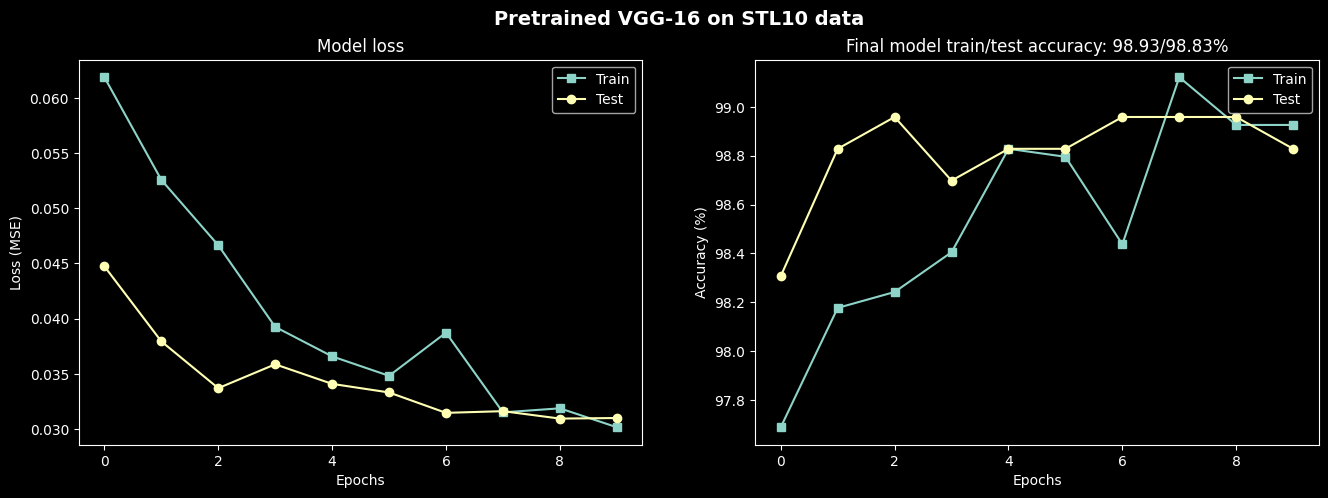

In [19]:
fig,ax = plt.subplots(1,2,figsize=(16,5))

ax[0].plot(trainLoss,'s-',label='Train')
ax[0].plot(testLoss,'o-',label='Test')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss (MSE)')
ax[0].set_title('Model loss')
ax[0].legend()

ax[1].plot(trainAcc,'s-',label='Train')
ax[1].plot(testAcc,'o-',label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model train/test accuracy: {trainAcc[-1]:.2f}/{testAcc[-1]:.2f}%')
ax[1].legend()

plt.suptitle('Pretrained VGG-16 on STL10 data',fontweight='bold',fontsize=14)
plt.show()

# conclusion

- Model 1 is a CNN model with 5 convolutional layers and 2 fully connected layers. The accuracy is 78.12% with 20 epochs.

- Model 2 is a ResNet transfer learning model, with 3 additional fully connected layers. The accuracy reaches  91.41% with 10 epochs.


- Model 3 is a VGG16 transfer learning model, with no additional layers. The accuracy reaches  98.83% with 10 epochs.